# 2 Simulating Price and Funding Fees

1. Compared to the volatility of the underlying, what is the likelihood that I will profit in this scenario? (Portfolio Size > 1)
   1. How volatile should the underlying be to make a profit? Is there an Analytical Solution?
   2. What is the likelihood that a leverage long position will make money?
   3. How different would the funding payoff be?
2. What is the expected amount that I will pay for cryptocurrencies? - screen through all possible tokens
3. What is the difference between me opening a position on Hyperliquid vs Binance?
   1. Notional
   2. Percentage per hour 
4. What is the optimal platform?
<!-- 7. How can I scale it to other platforms? -->

## Assumptions
- 2 Independent Random Distributions (Returns and Funding Fees)
- Spot price mirrors Perpetual - premium does not matter

## Future Extension
- Premium difference
- Max leverage varies by asset, ranging from 3x to 50x. Maintenance margin is half of the initial margin at max leverage. E.g., if max leverage is 20x, the maintenance margin is 2.5%.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json

from datetime import datetime, timedelta
import pytz

import scipy.stats as stats

In [3]:
def get_hyperliquid_funding(instrument, startTime, endTime = int(datetime.now(tz=pytz.UTC).timestamp() * 1000)):
    url = f"""https://api.hyperliquid.xyz/info"""
    headers = {
        "Content-Type" : "application/json",
    }
    all_data = []

    query_time = startTime
    print(f"""Hyperliquid : Querying funding data for {instrument} from {datetime.fromtimestamp(startTime/1000).strftime("%Y-%m-%d %H:%M:%S")} to {datetime.fromtimestamp(endTime/1000).strftime("%Y-%m-%d %H:%M:%S")}""")
    while query_time < endTime:
        payload = {
            "type": "fundingHistory",
            "coin": instrument,
            "startTime": query_time,
            "endTime": endTime
        }
        response = requests.post(url, headers=headers, json=payload)
        # return response.text
        if response.status_code != 200:
            raise Exception(f"Error {response.status_code} : {response.text}")
        data = response.json()
        if len(data) == 0:
            break
        all_data.extend(data)

        # update query_time
        query_time = data[-1]['time'] + 1

    return all_data

startTime = int(datetime(2023, 7, 1, 0, 0, 0, tzinfo=pytz.UTC).timestamp() * 1000)
data = get_hyperliquid_funding(instrument='BTC', startTime=startTime)
hl_df = pd.DataFrame(data)
hl_df['premium'] = hl_df['premium'].astype(float)
hl_df['fundingRate'] = hl_df['fundingRate'].astype(float)
hl_df['datetime'] = pd.to_datetime(hl_df['time'], unit='ms')
hl_df

Hyperliquid : Querying funding data for BTC from 2023-07-01 08:00:00 to 2025-02-22 16:06:13


,coin,fundingRate,premium,time,datetime
0,BTC,0.000051,0.000407,1688169600189,2023-07-01 00:00:00.189
1,BTC,0.000058,0.000463,1688173200008,2023-07-01 01:00:00.008
2,BTC,0.000049,0.000390,1688176800067,2023-07-01 02:00:00.067
3,BTC,0.000045,0.000361,1688180400024,2023-07-01 03:00:00.024
4,BTC,0.000040,0.000319,1688184000166,2023-07-01 04:00:00.166
...,...,...,...,...,...
14449,BTC,0.000037,0.000798,1740196800048,2025-02-22 04:00:00.048
14450,BTC,0.000041,0.000830,1740200400000,2025-02-22 05:00:00.000
14451,BTC,0.000013,0.000556,1740204000091,2025-02-22 06:00:00.091
14452,BTC,0.000013,0.000539,1740207600123,2025-02-22 07:00:00.123


# Understanding Returns Distribution

## Binance Prices

In [4]:
def get_binance_spot(symbol, interval, startTime, endTime):
    url = "https://api.binance.com/api/v3/klines"
    print(f"""Querying {symbol} from {datetime.fromtimestamp(startTime/1000).strftime("%Y-%m-%d %H:%M:%S")} to {datetime.fromtimestamp(endTime/1000).strftime("%Y-%m-%d %H:%M:%S")}""")
    queryTime = startTime
    all_data = []
    while queryTime < endTime:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": queryTime,
            "timeZone": 0,
            "limit": 1000
        }
        response = requests.get(url, params=params)
        data = response.json()
        # return data
        if len(data) == 0:
            break
        queryTime = data[-1][0] + 1
        all_data.extend(data)
    return all_data

startTime = int(datetime(2020, 1,1 , tzinfo=pytz.UTC).timestamp() * 1000)
endTime = int(datetime.now(pytz.UTC).timestamp() * 1000)

data_spot_btc = get_binance_spot("BTCUSDT", "1h", startTime=startTime, endTime=endTime)
# data_spot_btc
df_spot_btc = pd.DataFrame(data_spot_btc, columns=["timestamp", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"]).astype(float)
df_spot_btc["datetime"] = pd.to_datetime(df_spot_btc["timestamp"], unit="ms")
df_spot_btc = df_spot_btc[['timestamp', 'datetime', 'open', 'high', 'low', 'close', 'volume']]
df_spot_btc

Querying BTCUSDT from 2020-01-01 08:00:00 to 2025-02-22 16:06:24


,timestamp,datetime,open,high,low,close,volume
0,1.577837e+12,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901
1,1.577840e+12,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603
2,1.577844e+12,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809
3,1.577848e+12,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867
4,1.577851e+12,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578
...,...,...,...,...,...,...,...
45068,1.740197e+12,2025-02-22 04:00:00,96299.08,96470.59,96273.85,96387.36,379.908650
45069,1.740200e+12,2025-02-22 05:00:00,96387.36,96530.00,96312.00,96509.83,276.293030
45070,1.740204e+12,2025-02-22 06:00:00,96509.83,96578.99,96327.12,96395.18,421.813880
45071,1.740208e+12,2025-02-22 07:00:00,96395.19,96511.93,96288.09,96288.09,316.894430


## Bybit SPOT

In [5]:
# def get_bybit_kline(category, symbol, interval, start, end): 
#     url = " https://api.bybit.com/v5/market/kline"
#     params = {
#         "category": category,
#         "symbol": symbol,
#         "interval": interval,
#         "from": start,
#         "to": end,
#         "limit": 200
#     }
#     response = requests.get(url, params=params)
#     data = response.json()
#     return data

# start = int(datetime(2025, 1,1 , tzinfo=pytz.UTC).timestamp() * 1000)
# end = int(datetime.now(pytz.UTC).timestamp() * 1000)

# data = get_bybit_kline(category="spot", symbol= "BTCUSDT", interval="60", start=start, end=end)
# data

## How do the returns look like? What are the log returns distribution?

In [6]:
df_spot_btc['returns'] = df_spot_btc['close'] / df_spot_btc['close'].shift(1) - 1
df_spot_btc['returns_log'] = np.log(df_spot_btc['close'] / df_spot_btc['close'].shift(1))
"""
In Python Quarters are determined as follows:
1 - January to March
2 - April to June
3 - July to September
4 - October to December
"""
df_spot_btc['quarter'] = df_spot_btc['datetime'].dt.quarter
df_spot_btc['month'] = df_spot_btc['datetime'].dt.month
df_spot_btc['year'] = df_spot_btc['datetime'].dt.year
df_spot_btc

,timestamp,datetime,open,high,low,close,volume,returns,returns_log,quarter,month,year
0,1.577837e+12,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,NaN,NaN,1,1,2020
1,1.577840e+12,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,0.005469,0.005454,1,1,2020
2,1.577844e+12,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,0.003683,0.003677,1,1,2020
3,1.577848e+12,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,-0.002463,-0.002466,1,1,2020
4,1.577851e+12,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,-0.001071,-0.001072,1,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
45068,1.740197e+12,2025-02-22 04:00:00,96299.08,96470.59,96273.85,96387.36,379.908650,0.000917,0.000916,1,2,2025
45069,1.740200e+12,2025-02-22 05:00:00,96387.36,96530.00,96312.00,96509.83,276.293030,0.001271,0.001270,1,2,2025
45070,1.740204e+12,2025-02-22 06:00:00,96509.83,96578.99,96327.12,96395.18,421.813880,-0.001188,-0.001189,1,2,2025
45071,1.740208e+12,2025-02-22 07:00:00,96395.19,96511.93,96288.09,96288.09,316.894430,-0.001111,-0.001112,1,2,2025


In [7]:
df_spot_btc[['datetime', 'returns', 'returns_log']].describe()

,datetime,returns,returns_log
count,45073,45072.000000,45072.000000
mean,2022-07-29 02:00:24.999445248,0.000082,0.000058
min,2020-01-01 00:00:00,-0.182115,-0.201033
25%,2021-04-15 08:00:00,-0.002413,-0.002416
50%,2022-07-29 07:00:00,0.000075,0.000075
75%,2023-11-10 20:00:00,0.002617,0.002614
max,2025-02-22 08:00:00,0.173840,0.160280
std,NaN,0.006984,0.007002


In [8]:
def analyze_quarterly_returns(df, return_columns=['returns', 'returns_log']):
    """
    Analyze return statistics by quarter with improved formatting and readability.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing return data
    return_columns (list): List of column names for returns to analyze
    """
    def format_stats(stats_df):
        """Format statistics with consistent decimal places and alignment"""
        # Format all numeric columns to 4 decimal places
        formatted_df = stats_df.round(4)
        return formatted_df
    
    print("=" * 80)
    print("Quarterly Returns Analysis")
    print("=" * 80)
    
    for quarter in range(1, 5):
        # Filter data for current quarter
        quarterly_data = df[df['quarter'] == quarter].dropna()
        
        # Calculate number of observations
        n_obs = len(quarterly_data)
        
        print(f"\nQuarter {quarter} Analysis ({n_obs} observations)")
        print("-" * 40)
        
        # Get and format statistics
        stats = quarterly_data[return_columns].describe()
        formatted_stats = format_stats(stats)
        
        # Add additional readability spacing
        print(formatted_stats.to_string())
        
        # Add separator between quarters
        if quarter < 4:
            print("\n" + "-" * 80)

analyze_quarterly_returns(df_spot_btc)

Quarterly Returns Analysis

Quarter 1 Analysis (12094 observations)
----------------------------------------
          returns  returns_log
count  12094.0000   12094.0000
mean       0.0002       0.0001
std        0.0086       0.0086
min       -0.1821      -0.2010
25%       -0.0028      -0.0028
50%        0.0002       0.0002
75%        0.0031       0.0031
max        0.1738       0.1603

--------------------------------------------------------------------------------

Quarter 2 Analysis (10910 observations)
----------------------------------------
          returns  returns_log
count  10910.0000   10910.0000
mean      -0.0001      -0.0001
std        0.0074       0.0074
min       -0.0895      -0.0938
25%       -0.0026      -0.0026
50%       -0.0000      -0.0000
75%        0.0027       0.0027
max        0.0649       0.0629

--------------------------------------------------------------------------------

Quarter 3 Analysis (11034 observations)
----------------------------------------
     

In [9]:
# for i in range(1, 5, 1):
#     print(f"Quarter {i}")
#     df_spot_btc_q = df_spot_btc[df_spot_btc['quarter'] == i].dropna()
#     print(df_spot_btc_q[['returns', 'returns_log']].describe())

def analyze_returns_by_time(input_df, return_columns=['returns', 'returns_log']):
    """
    Analyze return statistics by year and quarter with improved formatting and readability.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing return data with a datetime column
    return_columns (list): Column names for the returns to analyze
    """
    df = input_df.copy()
    # Ensure we have datetime information
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extract year and quarter information
    df['year'] = df['datetime'].dt.year
    df['quarter'] = df['datetime'].dt.quarter
    
    def format_stats(stats_df):
        """Format statistics with consistent decimal places"""
        return stats_df.round(4)
    
    # Get unique years in the dataset
    years = sorted(df['year'].unique())
    
    # Print header
    print("=" * 100)
    print("Returns Analysis by Year and Quarter")
    print("=" * 100)
    
    for year in years:
        # Create year header
        print(f"\nYear {year}")
        print("=" * 50)
        
        yearly_data = df[df['year'] == year]
        
        # Print yearly summary first
        n_obs_year = len(yearly_data)
        print(f"\nYearly Summary ({n_obs_year} observations)")
        print("-" * 40)
        yearly_stats = format_stats(yearly_data[return_columns].describe())
        print(yearly_stats.to_string())
        print("\nQuarterly Breakdown:")
        print("-" * 40)
        
        # Analyze each quarter within the year
        for quarter in range(1, 5):
            quarterly_data = yearly_data[yearly_data['quarter'] == quarter].dropna()
            n_obs = len(quarterly_data)
            
            # Skip if no data for this quarter
            if n_obs == 0:
                print(f"\nQ{quarter}: No data available")
                continue
            
            print(f"\nQ{quarter} ({n_obs} observations)")
            print("-" * 30)
            
            # Calculate and format quarterly statistics
            stats = quarterly_data[return_columns].describe()
            formatted_stats = format_stats(stats)
            print(formatted_stats.to_string())
        
        # Add separator between years
        if year != years[-1]:
            print("\n" + "=" * 100)

    # Print overall summary at the end
    print("\n" + "=" * 100)
    print("Overall Summary")
    print("=" * 100)
    total_obs = len(df)
    print(f"\nTotal Observations: {total_obs}")
    print("-" * 40)
    overall_stats = format_stats(df[return_columns].describe())
    print(overall_stats.to_string())

# Example usage:
analyze_returns_by_time(df_spot_btc)

Returns Analysis by Year and Quarter

Year 2020

Yearly Summary (8766 observations)
----------------------------------------
         returns  returns_log
count  8765.0000    8765.0000
mean      0.0002       0.0002
std       0.0080       0.0080
min      -0.1821      -0.2010
25%      -0.0023      -0.0023
50%       0.0002       0.0002
75%       0.0027       0.0027
max       0.1738       0.1603

Quarterly Breakdown:
----------------------------------------

Q1 (2176 observations)
------------------------------
         returns  returns_log
count  2176.0000    2176.0000
mean      0.0000      -0.0001
std       0.0119       0.0121
min      -0.1821      -0.2010
25%      -0.0029      -0.0029
50%       0.0002       0.0002
75%       0.0031       0.0031
max       0.1738       0.1603

Q2 (2179 observations)
------------------------------
         returns  returns_log
count  2179.0000    2179.0000
mean      0.0002       0.0002
std       0.0068       0.0068
min      -0.0876      -0.0917
25%      -0.

In [10]:
def create_returns_table(input_df, return_columns=['returns', 'returns_log']):
    # Ensure datetime format and create time columns
    df = input_df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['quarter'] = df['datetime'].dt.quarter
    
    # Get unique years for our columns
    years = sorted(df['year'].unique())
    
    # Initialize dictionary to store our results
    results = {}
    
    # Function to calculate statistics for a subset of data
    def get_stats(data, prefix=''):
        if len(data) == 0:
            return pd.Series({
                f'{prefix}count': 0,
                f'{prefix}mean': np.nan,
                f'{prefix}std': np.nan,
                f'{prefix}min': np.nan,
                f'{prefix}25%': np.nan,
                f'{prefix}50%': np.nan,
                f'{prefix}75%': np.nan,
                f'{prefix}max': np.nan
            })
        
        stats = data.describe()
        return pd.Series({
            f'{prefix}count': stats['count'],
            f'{prefix}mean': stats['mean'],
            f'{prefix}std': stats['std'],
            f'{prefix}min': stats['min'],
            f'{prefix}25%': stats['25%'],
            f'{prefix}50%': stats['50%'],
            f'{prefix}75%': stats['75%'],
            f'{prefix}max': stats['max']
        })
    
    # Create MultiIndex columns
    columns = pd.MultiIndex.from_product([years, ['Year'] + list(range(1, 5))],
                                       names=['Year', 'Quarter'])
    
    # Initialize DataFrames for each return type
    tables = {}
    
    for col in return_columns:
        data_dict = {}
        
        # Calculate statistics for each time period
        for year in years:
            yearly_data = df[df['year'] == year]
            
            # Get yearly stats
            data_dict[(year, 'Year')] = get_stats(yearly_data[col])
            
            # Get quarterly stats
            for quarter in range(1, 5):
                quarterly_data = yearly_data[yearly_data['quarter'] == quarter]
                data_dict[(year, quarter)] = get_stats(quarterly_data[col])
        
        # Create DataFrame with hierarchical columns
        table = pd.DataFrame.from_dict(data_dict)
        table.columns = pd.MultiIndex.from_tuples(data_dict.keys(), 
                                                names=['Year', 'Period'])
        tables[col] = table
    
    # Combine all return types into one DataFrame
    final_table = pd.concat(tables, axis=0, keys=return_columns)
    
    # Format the table
    formatted_table = final_table.round(4)
    
    return formatted_table

def display_returns_analysis(df, return_columns=['returns', 'returns_log']):
    """
    Create and display a formatted analysis of returns.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing return data
    return_columns (list): List of return columns to analyze
    """
    # Create the analysis table
    table = create_returns_table(df, return_columns)
    
    # Display settings for better readability
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_rows', None)
    
    # Print the table with a title
    print("\nReturns Analysis by Year and Quarter")
    print("=" * 100)
    print(table)
    
    # Reset display settings
    pd.reset_option('all')

# Example usage:
display_returns_analysis(df_spot_btc.copy().dropna())


Returns Analysis by Year and Quarter
Year                    2020                                              \
Period                  Year          1          2          3          4   
returns     count  8765.0000  2176.0000  2179.0000  2208.0000  2202.0000   
            mean      0.0002     0.0000     0.0002     0.0001     0.0005   
            std       0.0080     0.0119     0.0068     0.0048     0.0066   
            min      -0.1821    -0.1821    -0.0876    -0.0692    -0.0450   
            25%      -0.0023    -0.0029    -0.0022    -0.0018    -0.0024   
            50%       0.0002     0.0002     0.0001     0.0001     0.0004   
            75%       0.0027     0.0031     0.0027     0.0020     0.0034   
            max       0.1738     0.1738     0.0474     0.0409     0.0375   
returns_log count  8765.0000  2176.0000  2179.0000  2208.0000  2202.0000   
            mean      0.0002    -0.0001     0.0002     0.0001     0.0004   
            std       0.0080     0.0121     0.0068

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_2176/577701394.py:98: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_2176/577701394.py:98: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


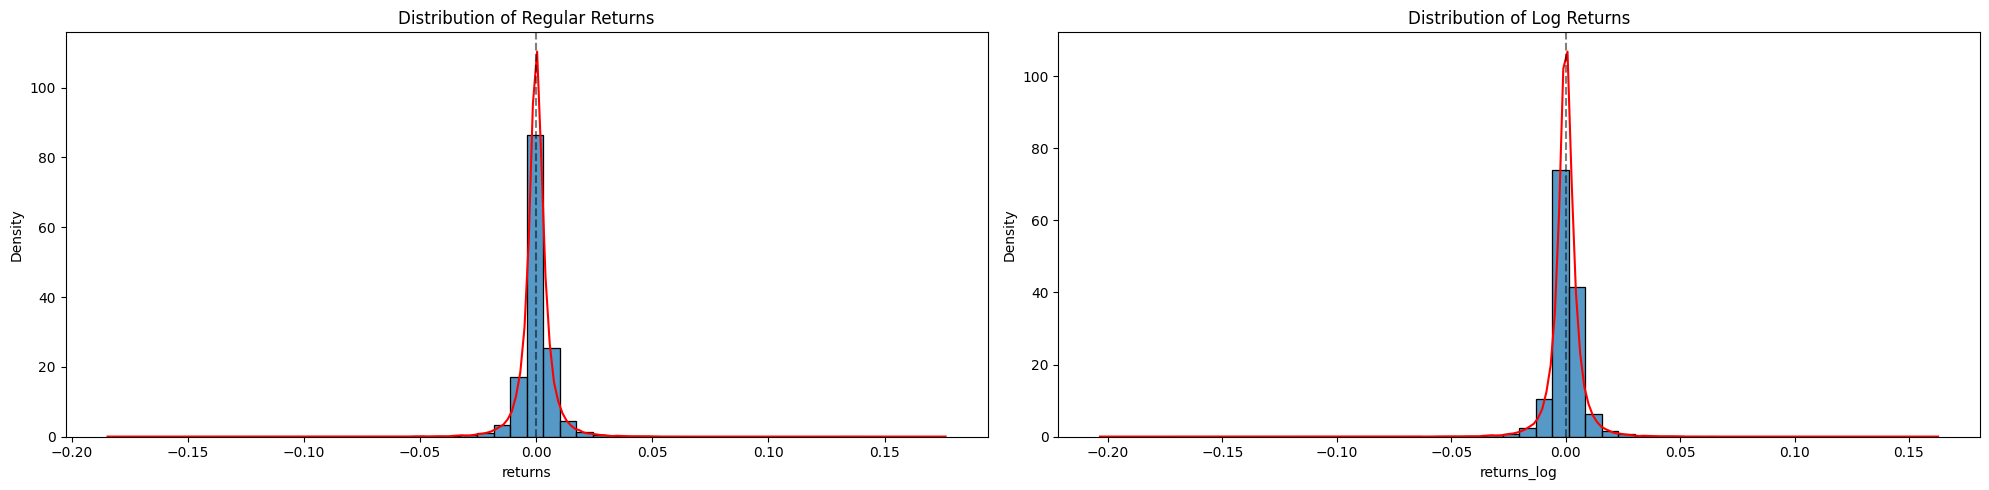

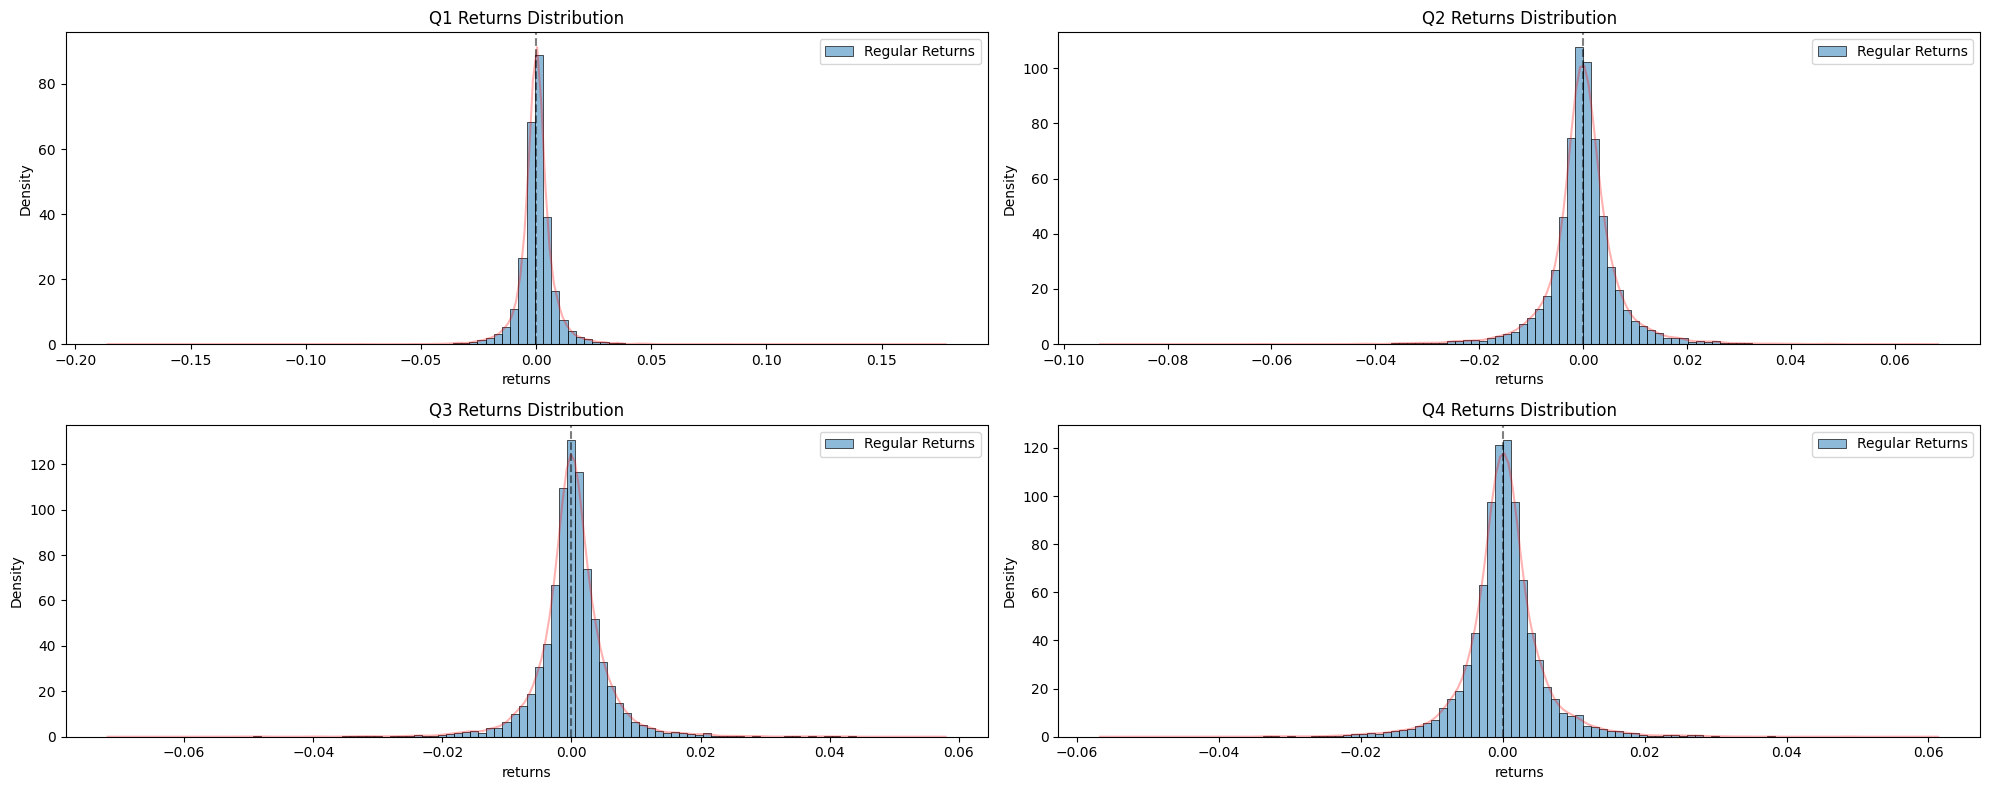

In [11]:
def analyze_returns_distribution(input_df):
    df = input_df.copy()
    # Convert datetime if it's not already in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Add quarter information
    df['quarter'] = df['datetime'].dt.quarter
    
    # Create figure for overall distributions - now in a single row
    plt.figure(figsize=(20, 5))
    
    # Regular returns distribution
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='returns', stat='density', bins=50)
    sns.kdeplot(data=df, x='returns', color='red')
    plt.title('Distribution of Regular Returns')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # Log returns distribution
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='returns_log', stat='density', bins=50)
    sns.kdeplot(data=df, x='returns_log', color='red')
    plt.title('Distribution of Log Returns')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Quarterly analysis with reduced height
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 8))
    axes = [ax1, ax2, ax3, ax4]
    
    for quarter in range(1, 5):
        quarter_data = df[df['quarter'] == quarter]
        ax = axes[quarter-1]
        
        # Plot both returns and log returns on the same subplot
        sns.histplot(data=quarter_data, x='returns', stat='density', bins=100, 
                    alpha=0.5, label='Regular Returns', ax=ax)
        sns.kdeplot(data=quarter_data, x='returns', color='red', ax=ax, alpha = 0.3)
        # sns.histplot(data=quarter_data, x='returns_log', stat='density', bins=100, 
        #             alpha=0.5, label='Log Returns', ax=ax)
        # sns.kdeplot(data=quarter_data, x='returns_log', color='blue', ax=ax, alpha = 0.3)
        
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Q{quarter} Returns Distribution')
        ax.legend()
        
        # Adjust y-axis limits to make the plots shorter
        # current_ylim = ax.get_ylim()
        # ax.set_ylim(0, current_ylim[1] * 0.8)  # Reduce height by 20%
    
    plt.tight_layout()
    plt.show()

# Example usage:
analyze_returns_distribution(df_spot_btc)

In [12]:
def analyze_cumulative_returns(df, return_columns=['returns', 'returns_log']):
    """
    Analyze cumulative returns by quarter and year, showing how returns compound
    within each period.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing return data with datetime and return columns
    return_columns (list): List of return column names to analyze
    """
    # Ensure datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['quarter'] = df['datetime'].dt.quarter
    
    def calculate_period_returns(data, return_col):
        """
        Calculate various return metrics for a given period.
        Returns cumulative return and other relevant statistics.
        """
        if len(data) == 0:
            return {
                'cumulative_return': np.nan,
                'avg_daily_return': np.nan,
                'volatility': np.nan,
                'num_observations': 0,
                'positive_days': np.nan,
                'negative_days': np.nan,
                'max_drawdown': np.nan
            }
        
        # Calculate cumulative return
        if return_col == 'returns_log':
            # For log returns, we can sum them
            cum_return = np.exp(data[return_col].sum()) - 1
        else:
            # For regular returns, we need to compound them
            cum_return = (1 + data[return_col]).prod() - 1
        
        # Calculate additional metrics
        avg_daily = data[return_col].mean()
        vol = data[return_col].std() * np.sqrt(252)  # Annualized volatility
        pos_days = (data[return_col] > 0).sum()
        neg_days = (data[return_col] < 0).sum()
        
        # Calculate maximum drawdown
        if return_col == 'returns_log':
            prices = np.exp(data[return_col].cumsum())
        else:
            prices = (1 + data[return_col]).cumprod()
        
        rolling_max = prices.expanding().max()
        drawdowns = prices / rolling_max - 1
        max_drawdown = drawdowns.min()
        
        return {
            'cumulative_return': cum_return,
            'avg_daily_return': avg_daily,
            'volatility': vol,
            'num_observations': len(data),
            'positive_days': pos_days,
            'negative_days': neg_days,
            'max_drawdown': max_drawdown
        }
    
    # Initialize results storage
    results = {}
    years = sorted(df['year'].unique())
    
    # Calculate statistics for each period
    for return_col in return_columns:
        period_results = {}
        
        for year in years:
            yearly_data = df[df['year'] == year]
            
            # Calculate yearly statistics
            yearly_stats = calculate_period_returns(yearly_data, return_col)
            period_results[(year, 'Year')] = yearly_stats
            
            # Calculate quarterly statistics
            for quarter in range(1, 5):
                quarterly_data = yearly_data[yearly_data['quarter'] == quarter]
                quarterly_stats = calculate_period_returns(quarterly_data, return_col)
                period_results[(year, quarter)] = quarterly_stats
        
        results[return_col] = period_results
    
    # Create formatted DataFrames for display
    formatted_tables = {}
    metrics = ['cumulative_return', 'avg_daily_return', 'volatility', 
               'num_observations', 'positive_days', 'negative_days', 'max_drawdown']
    
    for return_col in return_columns:
        # Create DataFrame from results
        table_data = pd.DataFrame.from_dict(results[return_col], orient='index')
        
        # Create MultiIndex
        table_data.index = pd.MultiIndex.from_tuples(results[return_col].keys(),
                                                   names=['Year', 'Period'])
        
        # Format numbers
        table_data['cumulative_return'] = table_data['cumulative_return'].map('{:.2%}'.format)
        table_data['avg_daily_return'] = table_data['avg_daily_return'].map('{:.4%}'.format)
        table_data['volatility'] = table_data['volatility'].map('{:.2%}'.format)
        table_data['max_drawdown'] = table_data['max_drawdown'].map('{:.2%}'.format)
        
        formatted_tables[return_col] = table_data
    
    return formatted_tables

def display_cumulative_analysis(df, return_columns=['returns', 'returns_log']):
    """
    Display the cumulative returns analysis in a clear, readable format.
    """
    tables = analyze_cumulative_returns(df, return_columns)
    
    print("\nCumulative Returns Analysis by Year and Quarter")
    print("=" * 100)
    
    for return_type, table in tables.items():
        print(f"\n{return_type.upper()} Analysis")
        print("-" * 80)
        print(table)
        print("\n")

# Example usage:
display_cumulative_analysis(df_spot_btc)


Cumulative Returns Analysis by Year and Quarter

RETURNS Analysis
--------------------------------------------------------------------------------
            cumulative_return avg_daily_return volatility  num_observations  \
Year Period                                                                   
2020 Year             303.00%          0.0191%     12.65%              8766   
     1                -10.68%          0.0020%     18.92%              2177   
     2                 42.56%          0.0186%     10.81%              2179   
     3                 17.92%          0.0086%      7.58%              2208   
     4                168.39%          0.0470%     10.49%              2202   
2021 Year              59.79%          0.0096%     14.60%              8747   
     1                103.09%          0.0393%     18.14%              2158   
     2                -40.34%         -0.0180%     16.95%              2179   
     3                 25.05%          0.0127%     11.38%     

## Conclusion
- Slight skew in Q1 and Q4 Returns. Only have had '2 cycles' of bull market.
- Cumulative Returns has been positive 3 / 5 years, with cumualtive returns -1.53% and -10.68%. Not doubt, this is a huge assumption, but we want to attempt to model the performance in Q1 based on the sample size. 

## Compared to the volatility of the underlying, what is the likelihood that I will profit in this scenario?

### Some Questions
   1. How volatile should the underlying be to make a profit? Is there an Analytical Solution?
   2. What is the likelihood that a leverage long position will make money?
   3. How different would the funding payoff be?

### Thoughts
Choice of distribution and dataset could significantly alter the results of this simulation. Some constraints that we face
- This strategy is based on the assumption that Q1 and Q4 is generally bullish. So, is it safe to incorporate this bias into the model? Do we only use Q1 returns?
- What happens when we only use Q1 Returns vs All Returns (assuming no change in returns patterns)?
- Hourly Funding Rates - obtained from Hyperliquid, dates back to 2023 July. Given the lack of data for funding, is it safe to be using funding from only Q1? But then the sample size would be small. If I use all the funding data to generate the distribution for funding fees, and then use only Q1 returns for simulating returns, would it have a significant effect on the results?
- Does using returns differ from log returns?

### Future Iterations
- Returns are often autocorrelated, so it is hard to simulate this price action. We have to assume random walk for returns. How can we encode autocorrelation into the model?

### Monte Carlo Simulation (Funding + Returns)

#### Scenario 1: All Funding + All Returns

In [13]:
def generate_samples(data, n_steps, dist_type='kde', random_state=None):
    # Set random state for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    if dist_type == 'kde':
        # For KDE, we need to set the random state explicitly
        kde = stats.gaussian_kde(data)
        # Store the original random state
        original_state = np.random.get_state()
        # Set the random state for this specific sampling
        np.random.seed(random_state)
        samples = kde.resample(n_steps)[0]
        # Restore the original random state
        np.random.set_state(original_state)
        return samples
    
    # elif dist_type == 'gamma':
    #     # Fit gamma distribution parameters
    #     shape, loc, scale = stats.gamma.fit(data)
    #     # Generate samples with explicit random_state
    #     return stats.gamma.rvs(shape, loc=loc, scale=scale, 
    #                          size=n_steps, random_state=random_state)
    
    elif dist_type == 'pearson':
        # Fit Pearson Type III distribution parameters
        shape, loc, scale = stats.pearson3.fit(data)
        # Generate samples with explicit random_state
        return stats.pearson3.rvs(shape, loc=loc, scale=scale, 
                                size=n_steps, random_state=random_state)
    
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")


def simulate_portfolio_fundingandreturns(funding_rates_df, hourly_funding_col, returns_df, returns_col, num_simulations, duration_hours, dist_type, initial_size, random_state = 42):
    rates = funding_rates_df[hourly_funding_col].values
    returns = returns_df[returns_col].values

    # Initialize arrays
    funding_rates = np.zeros((num_simulations, duration_hours))
    returns_data = np.zeros((num_simulations, duration_hours))
    total_fees = np.zeros(num_simulations)
    portfolio_values = np.zeros((num_simulations, duration_hours + 1))
    
    portfolio_values[:, 0] = initial_size

    for i in range(num_simulations):
        funding_rates[i] = generate_samples(data=rates, n_steps=duration_hours, dist_type=dist_type, random_state=random_state + i)
        returns_data[i] = generate_samples(data=returns, n_steps=duration_hours, dist_type=dist_type, random_state=random_state + i)

        fees = 0

        for t in range(duration_hours):
            portfolio_values[i, t + 1] = portfolio_values[i, t] * (1 + returns_data[i, t])
            funding_payment = portfolio_values[i, t] * (funding_rates[i, t])
            portfolio_values[i, t + 1] -= funding_payment
            fees += funding_payment
            total_fees[i] = fees

    # Create visualization
    plt.figure(figsize=(20, 10))
    time_points = np.arange(duration_hours + 1)
    
    # Plot all individual paths with low opacity
    for path in portfolio_values:
        plt.plot(time_points / 24, path, color='blue', alpha=0.1)
    
    # Plot mean path with higher visibility
    mean_path = np.mean(portfolio_values, axis=0)
    plt.plot(time_points / 24, mean_path, color='red', linewidth=2, 
             label='Mean Portfolio Value')
    # Add summary statistics
    final_values = portfolio_values[:, -1]
    total_return = (final_values - initial_size) / initial_size * 100
    
    plt.text(0.02, 0.98, 
             f'Final Portfolio Statistics:\n' +
             f'Mean Value: {np.mean(final_values):.4f}\n' +
             f'Median Value: {np.median(final_values):.4f}\n' +
             f'Std Dev: {np.std(final_values):.4f}\n' +
             f'5th Percentile: {np.percentile(final_values, 5):.4f}\n' +
             f'95th Percentile: {np.percentile(final_values, 95):.4f}\n' +
             f'Mean Return: {np.mean(total_return):.2f}%',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.xlabel('Days')
    plt.ylabel(f'Portfolio Value (Starting from {initial_size})')
    plt.title(f'Monte Carlo Simulation of Portfolio Value After Funding Fees\n'
              f'{num_simulations} Paths Over {duration_hours/24:.0f} Days')
    plt.legend()
    plt.grid(True)
    plt.show()
    return portfolio_values, funding_rates, returns_data, total_fees

# portfolio_values_allreturns, funding_rates_allreturns, returns_allreturns, total_fees_allreturns = simulate_portfolio_fundingandreturns(
#     funding_rates_df=hl_df,
#     hourly_funding_col='fundingRate',
#     returns_df=df_spot_btc.copy().dropna(),
#     returns_col='returns',
#     num_simulations=10000,
#     duration_hours= 24 * 30 * 3,
#     dist_type='pearson',
#     initial_size=10000
# )

In [14]:
# pd.DataFrame(total_fees_allreturns).describe()

In [15]:
# df_allreturns = pd.DataFrame(portfolio_values_allreturns)
# df_allreturns['min_val'] = df_allreturns.min(axis=1)
# df_allreturns['pct_initial'] = ((df_allreturns['min_val'] - 10000) / 10000) * 100
# df_allreturns

In [16]:
# df_allreturns['min_val'].describe()


In [17]:
# df_allreturns['pct_initial'].describe()

#### Scenario 2: All Funding + Q1 Returns

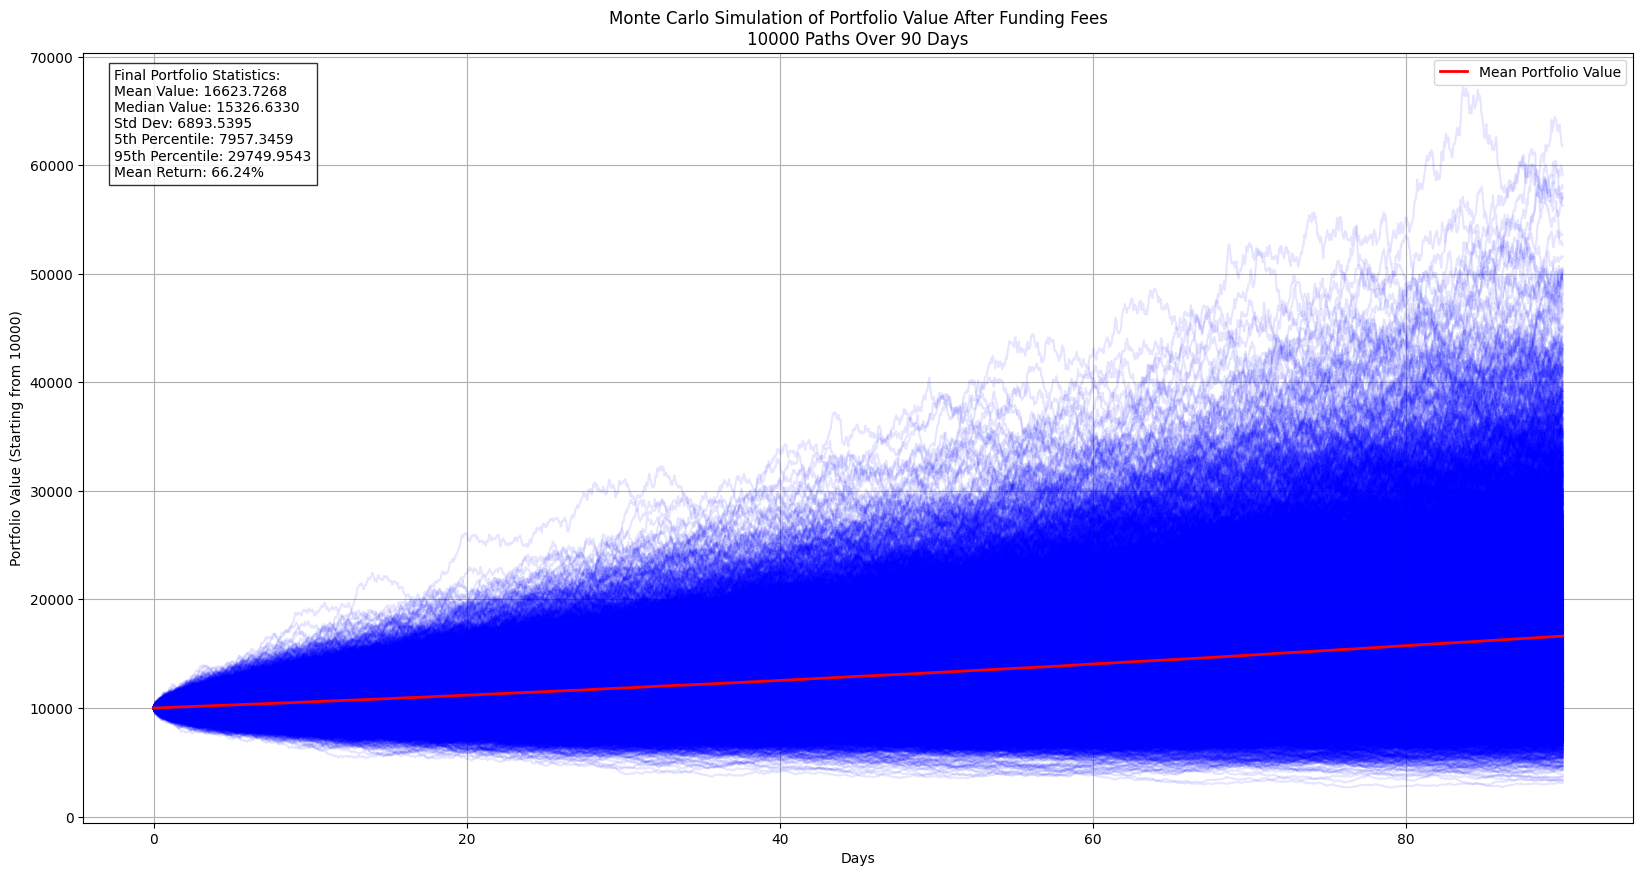

In [18]:
portfolio_values_q1returns, funding_rates_q1returns, returns_q1returns, total_fees_q1returns = simulate_portfolio_fundingandreturns(
    funding_rates_df=hl_df,
    hourly_funding_col='fundingRate',
    returns_df=df_spot_btc[df_spot_btc['quarter'] == 1].dropna(),
    returns_col='returns',
    num_simulations=10000,
    duration_hours= 24 * 30 * 3,
    dist_type='pearson',
    initial_size=10000
)

In [21]:
df_allreturns_q1returns = pd.DataFrame(portfolio_values_q1returns)
df_allreturns_q1returns['min_val'] = df_allreturns_q1returns.min(axis=1)
df_allreturns_q1returns['pct_initial'] = ((df_allreturns_q1returns['min_val'] - 10000) / 10000) * 100
df_allreturns_q1returns

,0,1,2,3,4,5,6,7,8,9,...,2153,2154,2155,2156,2157,2158,2159,2160,min_val,pct_initial
0,10000.0,9959.849025,9974.173808,9996.723820,10019.323407,9885.698838,9822.990098,9865.017903,9821.520583,9803.587108,...,8958.934072,8940.210242,8993.318720,8905.171803,8816.950723,8783.229107,8707.143346,8815.003657,7195.209094,-28.047909
1,10000.0,9980.414520,10060.644094,9988.978728,10026.882056,9920.504041,9960.376009,9992.485930,9955.920784,9916.272307,...,10271.249707,10258.475014,10240.967460,10176.527030,10091.438013,10202.641127,10165.420954,10087.827914,7308.419518,-26.915805
2,10000.0,10066.871270,9955.427948,10083.105804,10233.687443,10240.859095,10194.567708,10300.498673,10249.511310,10158.628986,...,14403.072636,14365.418575,14221.029336,14122.035635,14167.757036,14029.387762,13848.928003,13754.864203,9344.677762,-6.553222
3,10000.0,10000.253224,9980.416251,10091.651195,10318.238039,10295.167842,10374.827658,10378.835920,10358.312677,10516.159845,...,20296.371041,20317.420980,20353.783826,20236.644232,20251.117552,20236.541972,20282.736493,20273.667068,9980.416251,-0.195837
4,10000.0,9952.268991,9849.398114,9817.019317,9834.330083,9844.694084,9774.632434,9645.460164,9686.699113,9682.786422,...,7584.502198,7600.842399,7656.588165,7611.223836,7559.503815,7606.257422,7616.131319,7443.609977,7443.609977,-25.563900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10000.0,10174.417608,10332.561043,10366.883011,10188.205929,10096.122473,10103.436559,10017.379931,10116.528900,10092.065323,...,18243.494099,18220.713880,18384.581713,18447.909574,18342.323497,18382.413483,18535.089599,18706.283906,9696.616047,-3.033840
9996,10000.0,10063.294780,10107.605739,10190.108668,10241.008270,10224.740594,10314.356239,10366.463894,10369.107869,10462.874963,...,12288.167123,12316.876138,12311.819073,12362.050117,12279.762726,12266.118434,12137.620252,12193.085847,7789.498123,-22.105019
9997,10000.0,10052.530488,10114.748804,10172.562592,10270.944795,10145.768553,10112.499584,10154.576927,10114.848946,10075.053033,...,22134.708240,21880.160844,22270.502654,22450.557292,22613.462170,22538.807007,22716.950090,22780.753076,9129.175985,-8.708240
9998,10000.0,10022.238288,9950.663653,10055.758520,9942.182461,9932.927075,9964.007942,9878.982139,9968.346978,10161.310349,...,18264.721585,18196.861277,18394.529613,18355.841250,18390.485206,17988.634734,18013.236020,18118.243282,9043.178948,-9.568211


In [22]:
df_allreturns_q1returns[['min_val', 'pct_initial']].describe()

,min_val,pct_initial
count,10000.000000,10000.000000
mean,8632.306244,-13.676938
std,1159.856910,11.598569
min,2659.752006,-73.402480
25%,7984.785200,-20.152148
50%,8912.257141,-10.877429
75%,9563.300550,-4.366995
max,10000.000000,0.000000


In [23]:
(df_allreturns_q1returns[df_allreturns_q1returns['pct_initial'] <= -50].shape[0] / df_allreturns_q1returns.shape[0]) * 100

0.8500000000000001